In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import os

def load_images(image_dir, image_size=(32, 32)):
    images = []
    labels = []
    for label in os.listdir(image_dir):
        label_dir = os.path.join(image_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                image = Image.open(image_path).convert('L').resize(image_size)
                image_array = np.array(image).flatten()
                # Binarize image: convert to 1 (white) or -1 (black)
                image_array = np.where(image_array > 128, 1, -1)
                images.append(image_array)
                labels.append(label)
    return np.array(images), np.array(labels)

image_dir = 'animal-image-classification/Animals'
images, labels = load_images(image_dir)


In [3]:
class HopfieldNetwork:
    def __init__(self):
        self.weights = None

    def train(self, patterns):
        num_patterns, num_neurons = patterns.shape
        self.weights = np.zeros((num_neurons, num_neurons))

        for pattern in patterns:
            pattern = pattern / np.linalg.norm(pattern)
            self.weights += np.outer(pattern, pattern)

        np.fill_diagonal(self.weights, 0)
        self.weights /= num_patterns

    def recall(self, pattern, steps=5):
        for _ in range(steps):
            pattern = np.sign(np.dot(pattern, self.weights))
        return pattern

    def energy(self, pattern):
        return -0.5 * np.dot(np.dot(pattern.T, self.weights), pattern)


In [4]:
hopfield_net = HopfieldNetwork()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Train the Hopfield network on the training images
hopfield_net.train(X_train)


In [5]:
def test_hopfield_network(network, test_images, test_labels, original_images):
    correct = 0
    for i, test_image in enumerate(test_images):
        output_image = network.recall(test_image)
        energy = network.energy(output_image)

        # Find the closest match in the original training images
        min_dist = np.inf
        matched_label = None
        for j, train_image in enumerate(original_images):
            dist = np.sum(np.abs(output_image - train_image))
            if dist < min_dist:
                min_dist = dist
                matched_label = y_train[j]

        print(f"True Label: {test_labels[i]}, Predicted Label: {matched_label}, Energy: {energy}")
        if matched_label == test_labels[i]:
            correct += 1

    accuracy = correct / len(test_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

test_hopfield_network(hopfield_net, X_test, y_test, X_train)


True Label: cats, Predicted Label: snakes, Energy: -108.00423502604167
True Label: cats, Predicted Label: snakes, Energy: -108.00423502604167
True Label: cats, Predicted Label: snakes, Energy: -108.00423502604167
True Label: dogs, Predicted Label: snakes, Energy: -108.00423502604167
True Label: snakes, Predicted Label: snakes, Energy: -108.00423502604167
True Label: cats, Predicted Label: snakes, Energy: -108.00423502604167
True Label: cats, Predicted Label: snakes, Energy: -108.00423502604167
True Label: snakes, Predicted Label: snakes, Energy: -108.00423502604167
True Label: dogs, Predicted Label: snakes, Energy: -108.00423502604167
True Label: snakes, Predicted Label: snakes, Energy: -108.00423502604167
True Label: snakes, Predicted Label: snakes, Energy: -108.00423502604167
True Label: dogs, Predicted Label: snakes, Energy: -108.00423502604167
True Label: dogs, Predicted Label: snakes, Energy: -108.00423502604167
True Label: cats, Predicted Label: snakes, Energy: -108.0042350260416

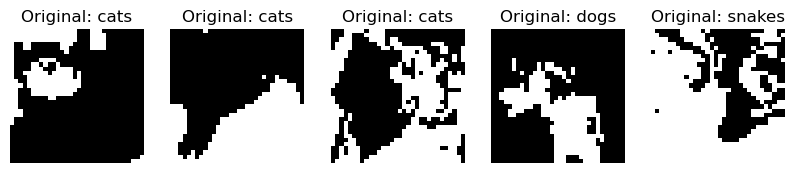

In [6]:
def visualize_results(network, test_images, test_labels):
    fig, axes = plt.subplots(1, 5, figsize=(10, 4))
    for i in range(5):
        original_image = test_images[i].reshape(32, 32)
        
        axes[i].imshow(original_image, cmap='gray')
        axes[i].set_title(f'Original: {test_labels[i]}')
        axes[i].axis('off')
    plt.show()

visualize_results(hopfield_net, X_test, y_test)


In [9]:
# Funkcja do przeprowadzenia analizy
import time
def analyze_hopfield_network(images, labels):
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    
    hopfield_net = HopfieldNetwork()
    hopfield_net.train(X_train)
    
    num_neurons = X_train.shape[1]
    
    # Analiza energii sieci
    energies = []
    for pattern in X_test:
        energies.append(hopfield_net.energy(pattern))
    
    avg_energy = np.mean(energies)
    print(f"Średnia energia sieci: {avg_energy:.2f}")
    
    # Wpływ liczby neuronów
    neuron_counts = [100, 200, 300, num_neurons]
    accuracy_per_neuron = []
    
    for n_neurons in neuron_counts:
        X_train_partial = X_train[:, :n_neurons]
        X_test_partial = X_test[:, :n_neurons]
        
        hopfield_net_partial = HopfieldNetwork()
        hopfield_net_partial.train(X_train_partial)
        
        correct = 0
        for i, test_pattern in enumerate(X_test_partial):
            recalled_pattern = hopfield_net_partial.recall(test_pattern)
            if np.array_equal(recalled_pattern, X_train_partial[i]):
                correct += 1
        
        accuracy = correct / len(X_test)
        accuracy_per_neuron.append(accuracy)
        print(f"Liczba neuronów: {n_neurons}, Dokładność: {accuracy * 100:.2f}%")
    
    # Pojemność sieci
    max_capacity = 0
    for num_patterns in range(1, X_train.shape[0] + 1):
        hopfield_net_capacity = HopfieldNetwork()
        hopfield_net_capacity.train(X_train[:num_patterns])
        
        stable_patterns = 0
        for pattern in X_train[:num_patterns]:
            recalled_pattern = hopfield_net_capacity.recall(pattern)
            if np.array_equal(recalled_pattern, pattern):
                stable_patterns += 1
        
        if stable_patterns == num_patterns:
            max_capacity = num_patterns
        else:
            break
    
    print(f"Maksymalna pojemność sieci: {max_capacity}")
    
    # Czas konwergencji
    convergence_times = []
    for pattern in X_test:
        start_time = time.time()
        recalled_pattern = hopfield_net.recall(pattern)
        end_time = time.time()
        convergence_times.append(end_time - start_time)
    
    avg_convergence_time = np.mean(convergence_times)
    print(f"Średni czas konwergencji: {avg_convergence_time:.4f} sekund")
    
    # Dokładność rozpoznawania wzorców
    correct = 0
    for i, test_pattern in enumerate(X_test):
        recalled_pattern = hopfield_net.recall(test_pattern)
        if np.array_equal(recalled_pattern, X_train[i]):
            correct += 1
    
    accuracy = correct / len(X_test)
    print(f"Dokładność rozpoznawania wzorców: {accuracy * 100:.2f}%")

# Wywołanie analizy dla obrazów (X) i etykiet (y)
analyze_hopfield_network(images, labels)

Średnia energia sieci: -32.30
Liczba neuronów: 100, Dokładność: 10.00%
Liczba neuronów: 200, Dokładność: 5.00%
Liczba neuronów: 300, Dokładność: 2.00%
Liczba neuronów: 1024, Dokładność: 0.17%
Maksymalna pojemność sieci: 5
Średni czas konwergencji: 0.0002 sekund
Dokładność rozpoznawania wzorców: 0.17%
